32
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] [1, 2, 4, 8, 16, 20, 39, 62, 116, 152, 286, 396, 748, 1024, 1893, 2512, 4485, 5638, 9529, 10878, 16993, 17110, 23952, 20224, 24047, 15578, 14560, 6274, 3910, 760, 221, 2]


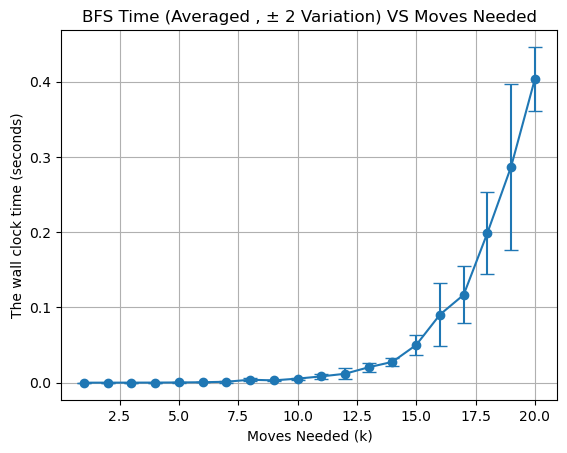

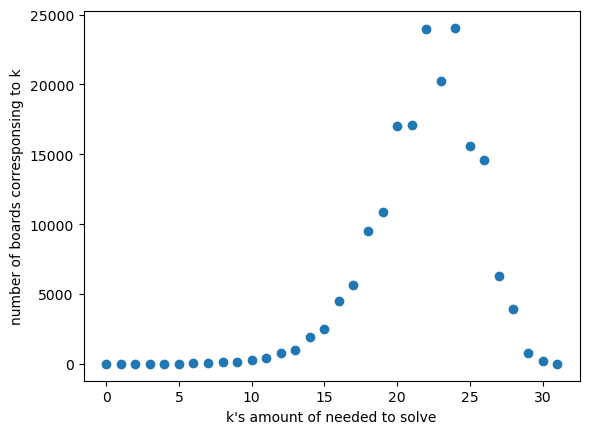

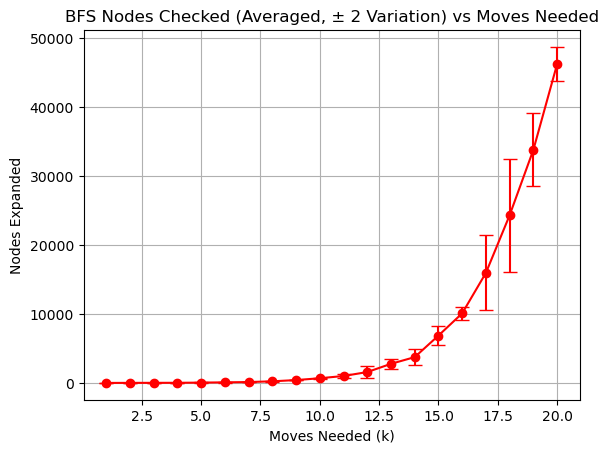

In [14]:
import random
import time
from collections import deque
import matplotlib.pyplot as plt
import numpy as np

# Convert string to 3x3 board
def string_to_board(state):
    board = []
    count = 0
    for i in range(3):
        row = []
        for j in range(3):
            row.append(state[count])
            count += 1
        board.append(row)
    return board

# Convert 3x3 board to string
def board_to_string(board):
    return ''.join(''.join(row) for row in board)

# Find blank tile position
def find_blank(board):
    for i in range(3):
        for j in range(3):
            if board[i][j] == '#':
                return (i, j)
    return None

# Check if move is valid
def check_move(x, y, direction):
    if direction == "LEFT" and y > 0:
        return (x, y - 1)
    if direction == "RIGHT" and y < 2:
        return (x, y + 1)
    if direction == "UP" and x > 0:
        return (x - 1, y)
    if direction == "DOWN" and x < 2:
        return (x + 1, y)
    return None

# Make a move on the board
def make_move(board, blank, move):
    if not move:
        return None
    x1, y1 = blank
    x2, y2 = move
    new_board = [row[:] for row in board]
    new_board[x1][y1], new_board[x2][y2] = new_board[x2][y2], new_board[x1][y1]
    return new_board

# Get all valid next states
def generate_successors(state):
    board = string_to_board(state)
    blank = find_blank(board)
    moves = ["LEFT", "UP", "DOWN", "RIGHT"]
    successors = []
    for move in moves:
        new_pos = check_move(blank[0], blank[1], move)
        if new_pos:
            new_board = make_move(board, blank, new_pos)
            if new_board:
                successors.append(board_to_string(new_board))
    return successors

# Find all states grouped by moves needed from goal
def find_states_by_moves_needed(goal): #boards that need exactly k moves
    states_by_moves = {}
    visited = set() 
    queue = deque([(goal, 0)])
    visited.add(goal)
    while queue:
        state, moves = queue.popleft() 
        states_by_moves.setdefault(moves, []).append(state)
        for succ in generate_successors(state):
            if succ not in visited: #when we expand it then that counts as node explored
                visited.add(succ)
                queue.append((succ, moves + 1))
    return states_by_moves 

# BFS to find path cost, time, and nodes checked
def bfs_to_measure(start, goal): #solve a random board needing k moves to solve it, choose a random of 5 board needing k moves, time each run and find avg and std
    start_time = time.perf_counter()
    visited = set()
    queue = deque([(start, 0)])
    visited.add(start)
    nodes_checked = 0
    while queue:
        state, depth = queue.popleft()
        nodes_checked += 1
        if state == goal:
            time_taken = time.perf_counter() - start_time
            return time_taken, nodes_checked, depth
        for succ in generate_successors(state): #find neighbours of 
            if succ not in visited:
                visited.add(succ)
                queue.append((succ, depth + 1))
    return None, None, None  # Should not happen

# Main part to run tests and plot
goal_state = "12345678#"
states_by_moves = find_states_by_moves_needed(goal_state)
print(len(states_by_moves))
max_k_value = min(max(states_by_moves.keys()), 20)  # Limit to 20 to run fast
k_list = [] 

time_averages = []
time_variations = []

space_averages = []
space_variations = []

for k in range(1, max_k_value + 1):
    times = []
    spaces = []
    for _ in range(5):
        start_state = random.choice(states_by_moves[k])
        time_taken, nodes_checked, depth = bfs_to_measure(start_state, goal_state)
        if depth == k:
            times.append(time_taken)
            spaces.append(nodes_checked)
    time_averages.append(np.mean(times))
    time_variations.append(2 * np.std(times))
    space_averages.append(np.mean(spaces))
    space_variations.append(2 * np.std(spaces))
    k_list.append(k)
k_s =[]
k_states = []
for i in range(32):
    k_s.append(i)
    k_states.append(len(states_by_moves[i]))
print(k_s, k_states)
# Plot time
plt.figure()
plt.errorbar(k_list, time_averages, yerr=time_variations, fmt='-o', capsize=5)
plt.xlabel('Moves Needed (k)')
plt.ylabel('The wall clock time (seconds)')
plt.title('BFS Time (Averaged , ± 2 Variation) VS Moves Needed')
plt.grid(True)
plt.show()
plt.savefig('time_plot.png')
plt.close()

#plot k vs the amount of possible states that need k moves to reach goal using BFS

plt.plot(k_s,k_states, "o")
plt.xlabel("k's amount of needed to solve")
plt.ylabel("number of boards corresponsing to k")
plt.show()

# Plot space
plt.figure()
plt.errorbar(k_list, space_averages, yerr=space_variations, fmt='-o', capsize=5, color='red')
plt.xlabel('Moves Needed (k)')
plt.ylabel('Nodes Expanded')
plt.title('BFS Nodes Checked (Averaged, ± 2 Variation) vs Moves Needed')
plt.grid(True)
plt.show()
plt.savefig('space_plot.png')
plt.close()

